# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities?
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

df = pd.read_csv("/content/cars_hw.csv")

print(df.isnull().sum())

Unnamed: 0           0
Make                 0
Make_Year            0
Color                0
Body_Type            0
Mileage_Run          0
No_of_Owners         0
Seating_Capacity     0
Fuel_Type            0
Transmission         0
Transmission_Type    0
Price                0
dtype: int64


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976 entries, 0 to 975
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         976 non-null    int64 
 1   Make               976 non-null    object
 2   Make_Year          976 non-null    int64 
 3   Color              976 non-null    object
 4   Body_Type          976 non-null    object
 5   Mileage_Run        976 non-null    int64 
 6   No_of_Owners       976 non-null    object
 7   Seating_Capacity   976 non-null    int64 
 8   Fuel_Type          976 non-null    object
 9   Transmission       976 non-null    object
 10  Transmission_Type  976 non-null    object
 11  Price              976 non-null    int64 
dtypes: int64(5), object(7)
memory usage: 91.6+ KB


In [3]:
df.head()

,Unnamed: 0,Make,Make_Year,Color,Body_Type,Mileage_Run,No_of_Owners,Seating_Capacity,Fuel_Type,Transmission,Transmission_Type,Price
0,1,Volkswagen,2017,silver,sedan,44611,1st,5,diesel,7-Speed,Automatic,657000
1,2,Hyundai,2016,red,crossover,20305,1st,5,petrol,5-Speed,Manual,682000
2,3,Honda,2019,white,suv,29540,2nd,5,petrol,5-Speed,Manual,793000
3,4,Renault,2017,bronze,hatchback,35680,1st,5,petrol,5-Speed,Manual,414000
4,5,Hyundai,2017,orange,hatchback,25126,1st,5,petrol,5-Speed,Manual,515000


In [4]:
print(df['No_of_Owners'].unique())

['1st' '2nd' '3rd']


In [5]:
owner_mapping = {
    '1st': 1,
    '2nd': 2,
    '3rd': 3,
}
df['No_of_Owners'] = df['No_of_Owners'].map(owner_mapping)

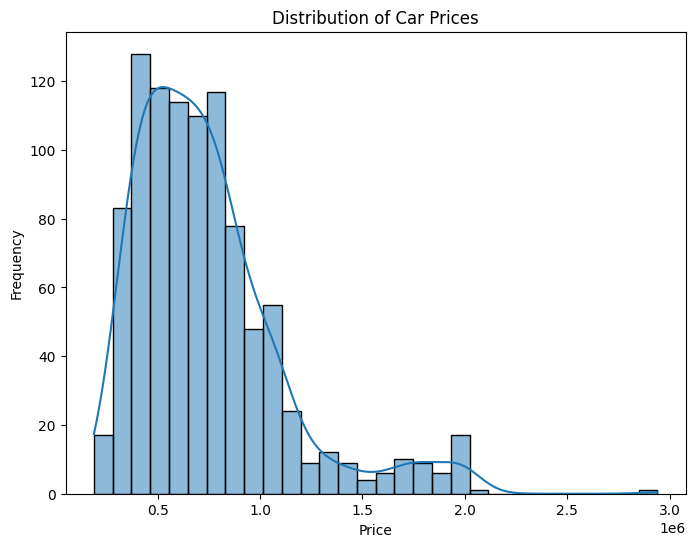

In [6]:
plt.figure(figsize=(8, 6))
sns.histplot(df['Price'], kde=True, bins=30)
plt.title("Distribution of Car Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

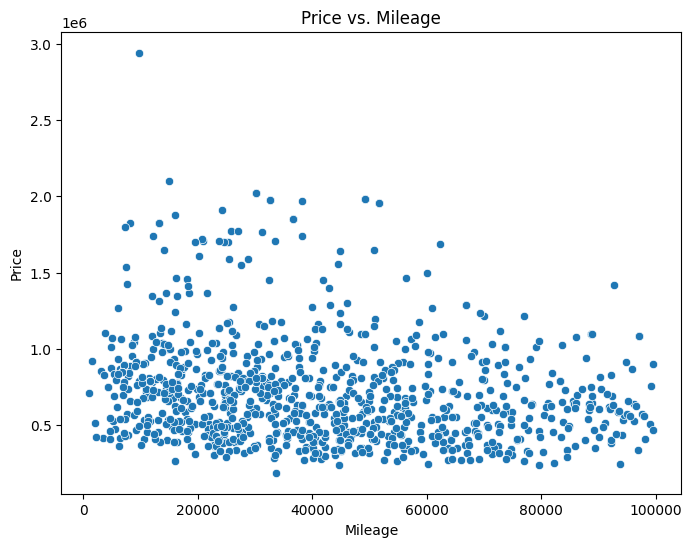

In [7]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Mileage_Run', y='Price')
plt.title("Price vs. Mileage")
plt.xlabel("Mileage")
plt.ylabel("Price")
plt.show()

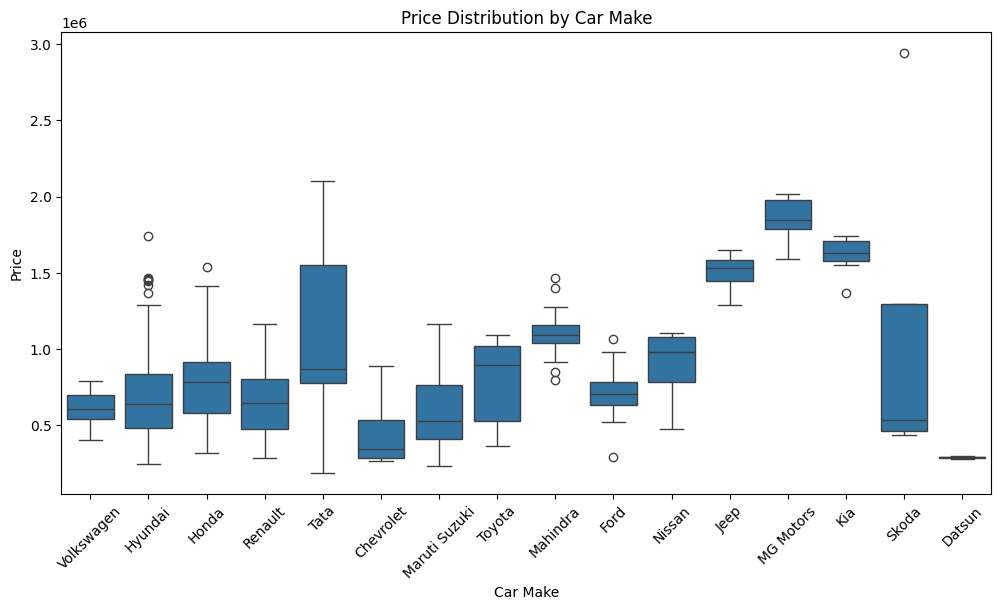

In [8]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Make', y='Price')
plt.title("Price Distribution by Car Make")
plt.xlabel("Car Make")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.show()

In [10]:
categorical_columns = ['make', 'model', 'transmission']
for col in categorical_columns:
    if col in df.columns:
        df[col] = df[col].astype('category')

In [26]:
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=22)
n_test = len(test)

model1 = smf.ols("Price ~ Mileage_Run", data=train).fit()
pred1 = model1.predict(test)
sse1 = np.sum((test["Price"] - pred1) ** 2)
rmse_model1 = np.sqrt(sse1 / n_test)
print(sse1, rmse_model1)

model2 = smf.ols("Price ~ Make_Year", data=train).fit()
pred2 = model2.predict(test)
sse2 = np.sum((test["Price"] - pred2) ** 2)
rmse_model2 = np.sqrt(sse2 / n_test)
print(sse2, rmse_model2)

23887172994002.367 349103.6115568742
16906121856441.488 293693.2477217591


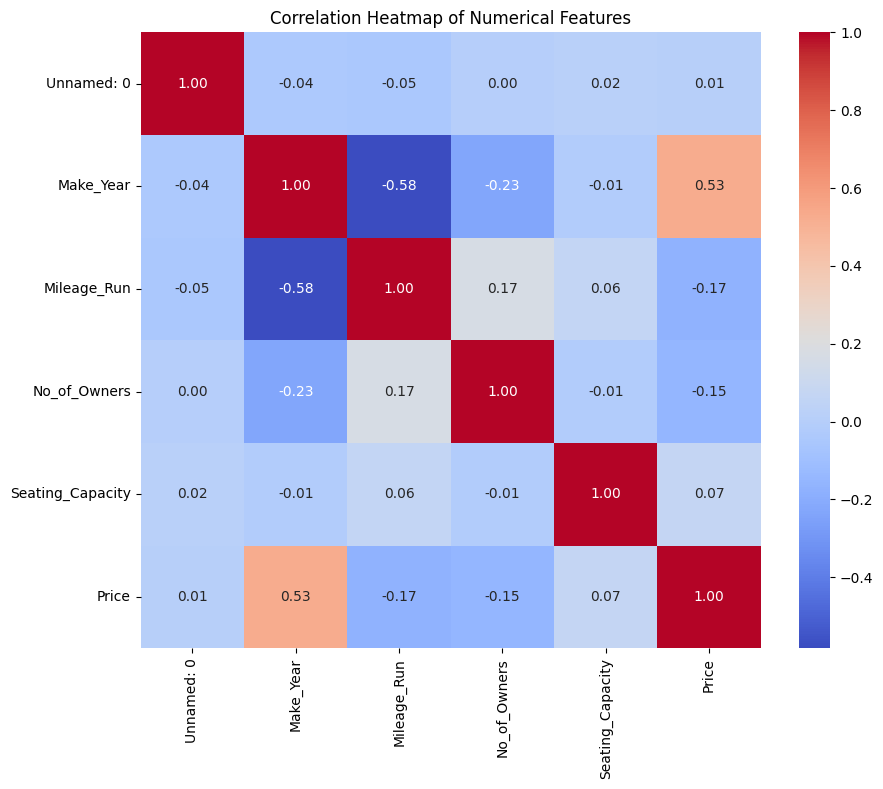

In [12]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(10, 8))
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

Milage is non linear, becasue the price most likley drops of harsh after a certain amount of milages. Make_Year is also most likley non-linear becasue the price depreciates must faster for older models than for newer ones.

In [23]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

features = ['Make_Year', 'Mileage_Run', 'No_of_Owners', 'Seating_Capacity']
X = df[features]
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

model = LinearRegression()
model.fit(X_train_poly, y_train)


y_train_pred = model.predict(X_train_poly)
y_test_pred = model.predict(X_test_poly)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)


rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)

print(rmse_train)
print(r2_train)
print(rmse_test)
print(r2_test)

301059.607378644
0.3385004200186146
282377.66850002133
0.36672427080790837


It looks like that the models perform more or less the same, the simple ones compared to the complicated one. The complicated one perfroms a little bit better.

While splitting the data set into test and trianing we can make sure the model isnt over fitted or under fitted. Also figuring out which model has the lowest RMSE is important for the model selection. Also, complicated models don't necessarily perform better than simple ones, what matters is which varibales are most useful for a prediction.